In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
import os
os.listdir()

['.config',
 'train_FD001.txt',
 'train_FD004.txt',
 'train_FD002.txt',
 'train_FD003.txt',
 '.ipynb_checkpoints',
 'sample_data']

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [39]:
# Define Column Names
column_names = (
    ['engine_id', 'cycle',
     'op_setting_1', 'op_setting_2', 'op_setting_3'] +
    [f'sensor_{i}' for i in range(1, 22)])

In [40]:
# Load Data Correctly
def fd_data(file_name):
    df = pd.read_csv(
        file_name,
        delim_whitespace=True,
        header=None,
        names=column_names)
    df['source_file'] = file_name
    return df

In [41]:
fd_1 = fd_data('train_FD001.txt')
fd_2 = fd_data('train_FD002.txt')
fd_3 = fd_data('train_FD003.txt')
fd_4 = fd_data('train_FD004.txt')

df = pd.concat([fd_1, fd_2, fd_3, fd_4], ignore_index=True)

/tmp/ipython-input-2334032436.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-2334032436.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-2334032436.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-2334032436.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [42]:
df['engine_id'].min(), df['engine_id'].max(), df['engine_id'].dtype

(0, 260, dtype('int64'))

In [43]:
# Basic Sanity Check
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165751 entries, 0 to 165750
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   engine_id     165751 non-null  int64  
 1   cycle         165751 non-null  float64
 2   op_setting_1  165751 non-null  float64
 3   op_setting_2  165751 non-null  float64
 4   op_setting_3  165751 non-null  float64
 5   sensor_1      165751 non-null  float64
 6   sensor_2      165751 non-null  float64
 7   sensor_3      165751 non-null  float64
 8   sensor_4      165751 non-null  float64
 9   sensor_5      165751 non-null  float64
 10  sensor_6      165751 non-null  float64
 11  sensor_7      165751 non-null  float64
 12  sensor_8      165751 non-null  float64
 13  sensor_9      165751 non-null  float64
 14  sensor_10     165750 non-null  float64
 15  sensor_11     165750 non-null  float64
 16  sensor_12     165750 non-null  float64
 17  sensor_13     165750 non-null  float64
 18  sens

In [44]:
# Compute Remaining Useful Life (RUL)
max_cycle = (
    df.groupby(['engine_id', 'source_file'])['cycle']
    .max()
    .reset_index())

max_cycle.columns = ['engine_id', 'source_file', 'max_cycle']

df = df.merge(max_cycle, on=['engine_id', 'source_file'])
df['rul'] = df['max_cycle'] - df['cycle']

In [45]:
# Create Failure Label (Classification Target)
threshold = 30
df['failure'] = (df['rul'] <= threshold).astype(int)
df['failure'].value_counts()

,count
failure,
0,143058
1,22693


In [46]:
# Use class imbalance handling
class_weight='balanced'

In [48]:
# Re-create features and target
drop_cols = ['engine_id', 'cycle', 'max_cycle', 'rul', 'source_file']
X = df.drop(columns=drop_cols + ['failure'])
y = df['failure']

In [49]:
# Train–test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [50]:
# Train or reuse the model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced')

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [53]:
# Evaluate the RIGHT metrics
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, rf.predict(X_test))

array([[28110,   502],
       [  712,  3827]])

In [57]:
# Analyze Model Errors
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, rf.predict(X_test))
cm

array([[28110,   502],
       [  712,  3827]])

In [58]:
# Tune the Decision Threshold
y_probs = rf.predict_proba(X_test)[:, 1]

for t in [0.2, 0.3, 0.4, 0.5]:
    y_pred = (y_probs >= t).astype(int)
    print(f"\nThreshold: {t}")
    print(confusion_matrix(y_test, y_pred))


Threshold: 0.2
[[27072  1540]
 [  228  4311]]

Threshold: 0.3
[[27585  1027]
 [  366  4173]]

Threshold: 0.4
[[27885   727]
 [  525  4014]]

Threshold: 0.5
[[28101   511]
 [  703  3836]]


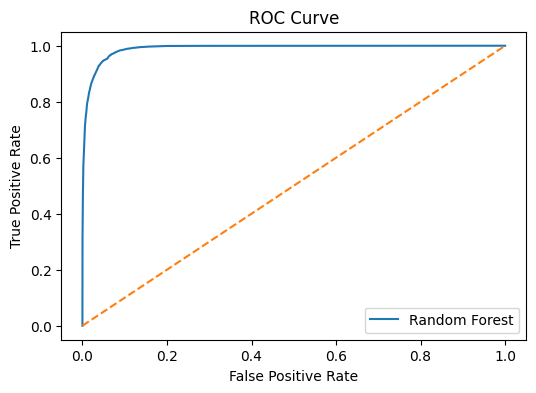

np.float64(0.9898914812171826)

In [59]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

roc_auc_score(y_test, y_probs)

In [60]:
# Feature Importance Analysis
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)

,0
sensor_13,0.147480
sensor_11,0.136986
sensor_4,0.103089
sensor_15,0.102957
sensor_14,0.053546
sensor_3,0.051326
sensor_9,0.048532
sensor_17,0.047342
sensor_8,0.047043
sensor_12,0.044770


In [61]:
# Feature Engineering
for sensor in ['sensor_2', 'sensor_4', 'sensor_7']:
    df[f'{sensor}_roll_mean'] = (
        df.groupby(['engine_id', 'source_file'])[sensor]
          .transform(lambda x: x.rolling(5).mean()))

    df[f'{sensor}_roll_std'] = (
        df.groupby(['engine_id', 'source_file'])[sensor]
          .transform(lambda x: x.rolling(5).std()))

In [62]:
# Drop NaNs:
df.dropna(inplace=True)

***Business Interpretation***

The model predicts failure risk up to ~30 cycles in advance, allowing preventive maintenance and reducing unplanned downtime.

In [63]:
# Saveing Model & Pipeline
import joblib
joblib.dump(rf, 'predictive_maintenance_model.pkl')

['predictive_maintenance_model.pkl']